In [1]:
!pip install wandb

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact BDD Semantic Segmentation:v0, 118.79MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.3
wandb: Downloading large artifact bdd_simple_1k_split:latest, 813.25MB. 4010 files... 
wandb:   4010 of 4010 files downloaded.  
Done. 0:0:43.4
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s] 
/opt/conda/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be e

### % Of Pixels In Each Class

,y_true,y_pred
background,67.5%,67.2%
road,21.3%,22.7%
traffic light,0.1%,0.0%
traffic sign,0.3%,0.0%
person,0.2%,0.0%
vehicle,10.6%,10.1%
bicycle,0.0%,0.0%


### % Of Pixels In Each Class

,y_true,y_pred
background,69.5%,70.3%
road,18.1%,19.3%
traffic light,0.1%,0.0%
traffic sign,0.7%,0.0%
person,0.2%,0.0%
vehicle,11.3%,10.4%
bicycle,0.0%,0.0%


test_background_iou,0.9137
test_bicycle_iou,0
test_loss,0.28095
test_miou,0.36556
test_person_iou,0
test_road_iou,0.79623
test_traffic_light_iou,0.0854
test_traffic_sign_iou,0
test_vehicle_iou,0.76357
val_background_iou,0.91702
val_bicycle_iou,0


<Figure size 640x480 with 0 Axes>

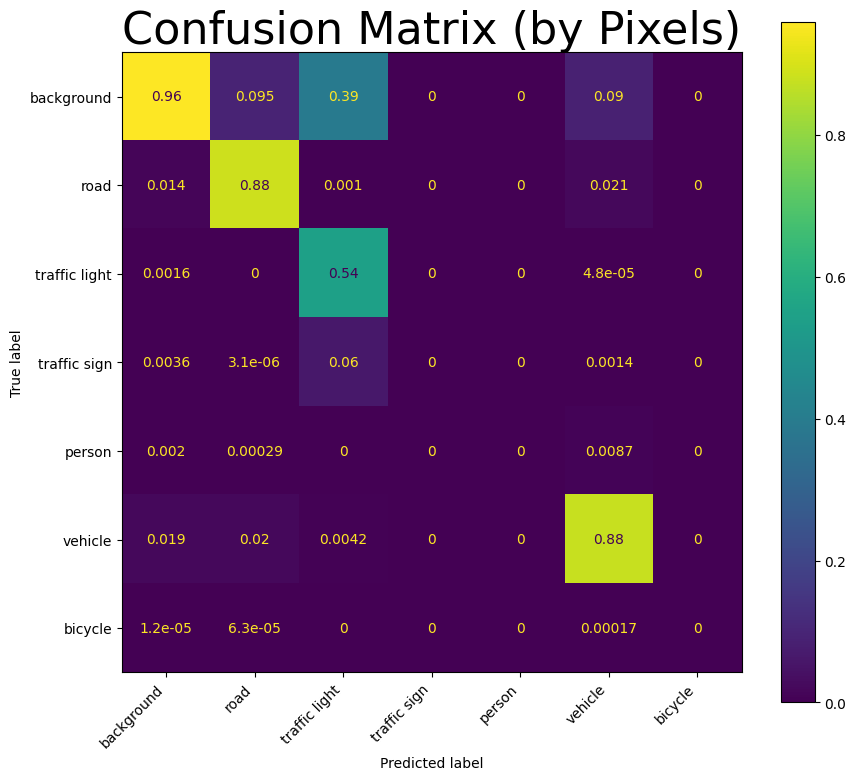

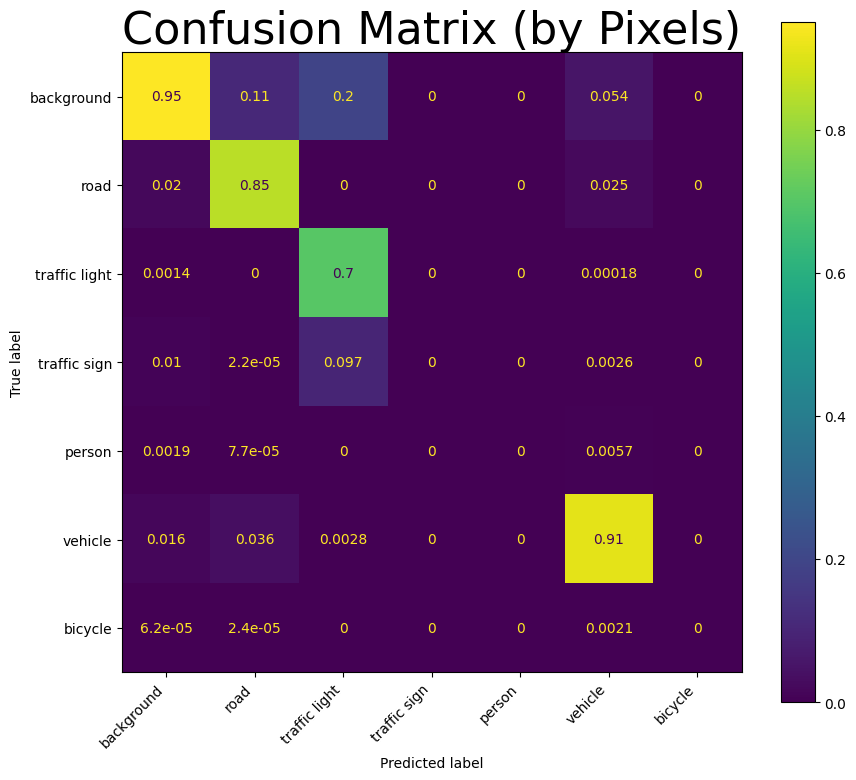

In [2]:
import wandb
import torchvision.models as tvmodels
import pandas as pd
from fastai.vision.all import *

from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import display, Markdown

WANDB_PROJECT = "mlops-course-001"
ENTITY = None
BDD_CLASSES = {i:c for i,c in enumerate(['background', 'road', 'traffic light', 'traffic sign', 'person', 'vehicle', 'bicycle'])}
RAW_DATA_AT = 'av-team/mlops-course-001/bdd_simple_1k'
PROCESSED_DATA_AT = 'av-team/mlops-course-001/bdd_simple_1k_split'

CLASS_INDEX = {v:k for k,v in BDD_CLASSES.items()}

def t_or_f(arg):
    ua = str(arg).upper()
    if 'TRUE'.startswith(ua): return True
    else: return False

def iou_per_class(inp, targ):
    "Compute iou per class"
    iou_scores = []
    for c in range(inp.shape[0]):
        dec_preds = inp.argmax(dim=0)
        p = torch.where(dec_preds == c, 1, 0)
        t = torch.where(targ == c, 1, 0)
        c_inter = (p * t).float().sum().item()
        c_union = (p + t).float().sum().item()
        iou_scores.append(c_inter / (c_union - c_inter) if c_union > 0 else np.nan)
    return iou_scores

def create_row(sample, pred_label, prediction, class_labels):
    """"A simple function to create a row of (img, target, prediction, and scores...)"""
    (image, label) = sample
    # compute metrics
    iou_scores = iou_per_class(prediction, label)
    image = image.permute(1, 2, 0)
    row =[wandb.Image(
                image,
                masks={
                    "predictions": {
                        "mask_data": pred_label[0].numpy(),
                        "class_labels": class_labels,
                    },
                    "ground_truths": {
                        "mask_data": label.numpy(),
                        "class_labels": class_labels,
                    },
                },
            ),
            *iou_scores,
    ]
    return row

def create_iou_table(samples, outputs, predictions, class_labels):
    "Creates a wandb table with predictions and targets side by side"

    def _to_str(l):
        return [f'{str(x)} IoU' for x in l]
    
    items = list(zip(samples, outputs, predictions))
    
    table = wandb.Table(
        columns=["Image"]
        + _to_str(class_labels.values()),
    )
    # we create one row per sample
    for item in progress_bar(items):
        table.add_data(*create_row(*item, class_labels=class_labels))
    
    return table

def get_predictions(learner, test_dl=None, max_n=None):
    """Return the samples = (x,y) and outputs (model predictions decoded), and predictions (raw preds)"""
    test_dl = learner.dls.valid if test_dl is None else test_dl
    inputs, predictions, targets, outputs = learner.get_preds(
        dl=test_dl, with_input=True, with_decoded=True
    )
    x, y, samples, outputs = learner.dls.valid.show_results(
        tuplify(inputs) + tuplify(targets), outputs, show=False, max_n=max_n
    )
    return samples, outputs, predictions

    def value(self): return self.inter/(self.union-self.inter) if self.union > 0 else None

class MIOU(DiceMulti):
    @property
    def value(self):
        binary_iou_scores = np.array([])
        for c in self.inter:
            binary_iou_scores = np.append(binary_iou_scores, \
                                          self.inter[c]/(self.union[c]-self.inter[c]) if self.union[c] > 0 else np.nan)
        return np.nanmean(binary_iou_scores)
    
class IOU(DiceMulti):
    @property
    def value(self): 
        c=CLASS_INDEX[self.nm]
        return self.inter[c]/(self.union[c]-self.inter[c]) if self.union[c] > 0 else np.nan

class BackgroundIOU(IOU): nm = 'background'
class RoadIOU(IOU): nm = 'road'
class TrafficLightIOU(IOU): nm = 'traffic light'
class TrafficSignIOU(IOU): nm = 'traffic sign'
class PersonIOU(IOU): nm = 'person'
class VehicleIOU(IOU): nm = 'vehicle'
class BicycleIOU(IOU): nm = 'bicycle'


class IOUMacro(DiceMulti):
    @property
    def value(self): 
        c=CLASS_INDEX[self.nm]
        if c not in self.count: return np.nan
        else: return self.macro[c]/self.count[c] if self.count[c] > 0 else np.nan

    def reset(self): self.macro,self.count = {},{}

    def accumulate(self, learn):
        pred,targ = learn.pred.argmax(dim=self.axis), learn.y
        for c in range(learn.pred.shape[self.axis]):
            p = torch.where(pred == c, 1, 0)
            t = torch.where(targ == c, 1, 0)
            c_inter = (p*t).float().sum(dim=(1,2))
            c_union = (p+t).float().sum(dim=(1,2))
            m = c_inter / (c_union - c_inter)
            macro = m[~torch.any(m.isnan())]
            count = macro.shape[1]

            if count > 0:
                msum = macro.sum().item()
                if c in self.count:
                    self.count[c] += count
                    self.macro[c] += msum
                else:
                    self.count[c] = count
                    self.macro[c] = msum


class MIouMacro(IOUMacro):
    @property
    def value(self):
        binary_iou_scores = np.array([])
        for c in self.count:
            binary_iou_scores = np.append(binary_iou_scores, self.macro[c]/self.count[c] if self.count[c] > 0 else np.nan)
        return np.nanmean(binary_iou_scores)


class BackgroundIouMacro(IOUMacro): nm = 'background'
class RoadIouMacro(IOUMacro): nm = 'road'
class TrafficLightIouMacro(IOUMacro): nm = 'traffic light'
class TrafficSignIouMacro(IOUMacro): nm = 'traffic sign'
class PersonIouMacro(IOUMacro): nm = 'person'
class VehicleIouMacro(IOUMacro): nm = 'vehicle'
class BicycleIouMacro(IOUMacro): nm = 'bicycle'


def display_diagnostics(learner, ds_idx=1, return_vals=False):
    """
    Display a confusion matrix for the unet learner.
    If `dls` is None it will get the validation set from the Learner
    
    You can create a test dataloader using the `test_dl()` method like so:
    >> dls = ... # You usually create this from the DataBlocks api, in this library it is get_data()
    >> tdls = dls.test_dl(test_dataframe, with_labels=True)
    
    See: https://docs.fast.ai/tutorial.pets.html#adding-a-test-dataloader-for-inference
    
    """
    probs, targs = learner.get_preds(ds_idx=ds_idx)
    preds = probs.argmax(dim=1)
    classes = list(BDD_CLASSES.values())
    y_true = targs.flatten().numpy()
    y_pred = preds.flatten().numpy()
    
    tdf, pdf = [pd.DataFrame(r).value_counts().to_frame(c) for r,c in zip((y_true, y_pred) , ['y_true', 'y_pred'])]
    countdf = tdf.join(pdf, how='outer').reset_index(drop=True).fillna(0).astype(int).rename(index= BDD_CLASSES)
    countdf = countdf/countdf.sum() 
    display(Markdown('### % Of Pixels In Each Class'))
    display(countdf.style.format('{:.1%}'))
    
    
    disp = ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred,
                                                   display_labels=classes,
                                                   normalize='pred')
    fig = disp.ax_.get_figure()
    fig.set_figwidth(10)
    fig.set_figheight(10) 
    disp.ax_.set_title('Confusion Matrix (by Pixels)', fontdict={'fontsize': 32, 'fontweight': 'medium'})
    fig.show()
    fig.autofmt_xdate(rotation=45)

    if return_vals: return countdf, disp



def create_dice_table(samples, outputs, predictions, class_labels):
    "Creates a wandb table with predictions and targets side by side"

    def _to_str(l):
        return [str(x) for x in l]
    
    items = list(zip(samples, outputs, predictions))
    
    table = wandb.Table(
        columns=["Image"]
        + _to_str(class_labels.values())
        + ["Foreground Acc"],
    )
    # we create one row per sample
    for item in progress_bar(items):
        table.add_data(*create_row(*item, class_labels=class_labels))
    
    return table

#Evaluation Script

def download_data():
    """Grab dataset from artifact
    @wandbcode{course-lesson3}
    """
    processed_data_at = wandb.use_artifact(f'{PROCESSED_DATA_AT}:latest')
    processed_dataset_dir = Path(processed_data_at.download())
    return processed_dataset_dir

def label_func(fname):
    return (fname.parent.parent/"labels")/f"{fname.stem}_mask.png"
        
def get_df(processed_dataset_dir, is_test=False):
    df = pd.read_csv(processed_dataset_dir / 'data_split.csv')
    
    if not is_test:
        df = df[df.Stage != 'test'].reset_index(drop=True)
        df['is_valid'] = df.Stage == 'valid'
    else:
        df = df[df.Stage != 'train'].reset_index(drop=True)
        df['is_valid'] = df.Stage == 'valid'
        # when passed to datablock, this will return test at index 0 and valid at index 1
    
    # assign paths
    df["image_fname"] = [processed_dataset_dir/f'images/{f}' for f in df.File_Name.values]
    df["label_fname"] = [label_func(f) for f in df.image_fname.values]
    return df

def get_data(df, bs=4, img_size=180, augment=True):
    block = DataBlock(blocks=(ImageBlock, MaskBlock(codes=BDD_CLASSES)),
                  get_x=ColReader("image_fname"),
                  get_y=ColReader("label_fname"),
                  splitter=ColSplitter(),
                  item_tfms=Resize((img_size, int(img_size * 16 / 9))),
                  batch_tfms=aug_transforms() if augment else None,
                 )
    return block.dataloaders(df, bs=bs)

def log_predictions(learn):
    "Log a Table with model predictions and metrics"
    samples, outputs, predictions = get_predictions(learn)
    table = create_iou_table(samples, outputs, predictions, BDD_CLASSES)
    wandb.log({"val_pred_table":table})
    
def count_by_class(arr, cidxs): 
    return [(arr == n).sum(axis=(1,2)).numpy() for n in cidxs]

def log_hist(c):
    _, bins, _ = plt.hist(target_counts[c],  bins=10, alpha=0.5, density=True, label='target')
    _ = plt.hist(pred_counts[c], bins=bins, alpha=0.5, density=True, label='pred')
    plt.legend(loc='upper right')
    plt.title(BDD_CLASSES[c])
    img_path = f'hist_val_{BDD_CLASSES[c]}'
    plt.savefig(img_path)
    plt.clf()
    im = plt.imread(f'{img_path}.png')
    wandb.log({img_path: wandb.Image(f'{img_path}.png', caption=img_path)})

run = wandb.init(project=WANDB_PROJECT, entity=ENTITY, job_type="evaluation", tags=['staging'])

artifact = run.use_artifact('semaljohari80/model-registry/BDD Semantic Segmentation:v0', type='model')

artifact_dir = Path(artifact.download())

_model_pth = artifact_dir.ls()[0]
model_path = _model_pth.parent.absolute()/_model_pth.stem

producer_run = artifact.logged_by()
wandb.config.update(producer_run.config)
config = wandb.config

processed_dataset_dir = download_data()
test_valid_df = get_df(processed_dataset_dir, is_test=True)
test_valid_dls = get_data(test_valid_df, bs=config.batch_size, img_size=config.img_size, augment=config.augment)

metrics = [MIOU(), BackgroundIOU(), RoadIOU(), TrafficLightIOU(),
           TrafficSignIOU(), PersonIOU(), VehicleIOU(), BicycleIOU()]

cbs = [MixedPrecision()] if config.mixed_precision else []

learn = unet_learner(test_valid_dls, arch=getattr(tvmodels, config.arch), pretrained=config.pretrained, 
                     metrics=metrics)

learn.load(model_path);

val_metrics = learn.validate(ds_idx=1)
test_metrics = learn.validate(ds_idx=0)

val_metric_names = ['val_loss'] + [f'val_{x.name}' for x in learn.metrics]
val_results = {val_metric_names[i] : val_metrics[i] for i in range(len(val_metric_names))}
for k,v in val_results.items(): 
    wandb.summary[k] = v

test_metric_names = ['test_loss'] + [f'test_{x.name}' for x in learn.metrics]
test_results = {test_metric_names[i] : test_metrics[i] for i in range(len(test_metric_names))}
for k,v in test_results.items(): 
    wandb.summary[k] = v
    
log_predictions(learn)

val_probs, val_targs = learn.get_preds(ds_idx=1)
val_preds = val_probs.argmax(dim=1)
class_idxs = BDD_CLASSES.keys()

target_counts = count_by_class(val_targs, class_idxs)
pred_counts = count_by_class(val_preds, class_idxs)

for c in class_idxs:
    log_hist(c)
    
val_count_df, val_disp = display_diagnostics(learner=learn, ds_idx=1, return_vals=True)
wandb.log({'val_confusion_matrix': val_disp.figure_})
val_ct_table = wandb.Table(dataframe=val_count_df)
wandb.log({'val_count_table': val_ct_table})

test_count_df, test_disp = display_diagnostics(learner=learn, ds_idx=0, return_vals=True)
wandb.log({'test_confusion_matrix': test_disp.figure_})
test_ct_table = wandb.Table(dataframe=test_count_df)
wandb.log({'test_count_table': test_ct_table})

run.finish()